Define functions to load in tables of varying depth

In [1]:
import pandas as pd
def filter_df(fname):
    # Load the entire DataFrame from a Parquet file
    df = pd.read_parquet(path + fname + '.parquet')

    for col in df.columns:
        if col[-1] in ("P", "A"):
            df[col] = df[col].astype('float32')

        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)

    return df

def depth1_feats(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    aggfeats = df.groupby('case_id')[numeric_cols].agg('sum').reset_index()

    notnum_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filfeats = df[df['num_group1'] == 0]
    filfeats = filfeats.drop('num_group1', axis=1)
    filfeats = filfeats.filter(items=notnum_cols)
    return pd.merge(filfeats, aggfeats, how='left', on='case_id')

def depth2_feats(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    numeric_cols.remove('num_group2')
    aggfeats = df.groupby('case_id')[numeric_cols].agg('sum').reset_index()

    notnum_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    df = df[df['num_group1'] == 0]
    df = df[df['num_group2'] == 0]
    filterdf = df.drop(['num_group1', 'num_group2'], axis=1)
    filterdf = filterdf.filter(items=notnum_cols)
    return pd.merge(filterdf, aggfeats, how='left', on='case_id') 

Load in base table

In [2]:
path = '/rds/general/user/ms2524/home/amexproject/parquet_files/train/train_'
base_cba = pd.read_parquet(path + "base.parquet", columns=['case_id','WEEK_NUM','target'])

In [3]:
base_cba["WEEK_NUM"].nunique()

92

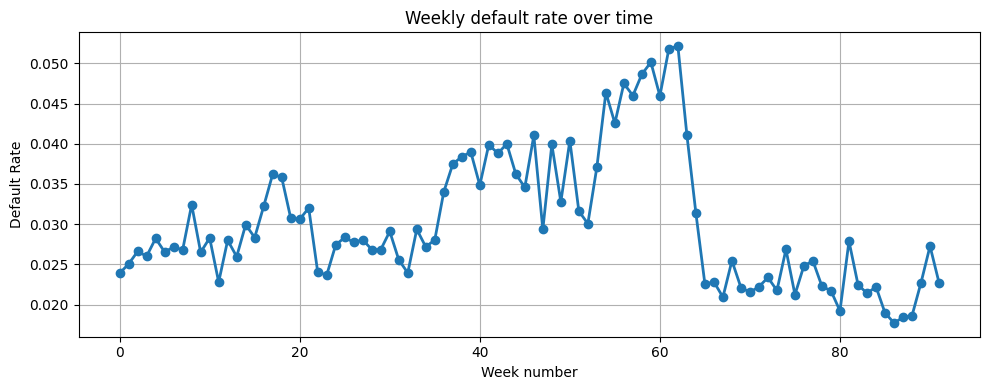

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

weekly_defaults = (
    base_cba
    .groupby('WEEK_NUM')['target']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.plot(weekly_defaults['WEEK_NUM'], weekly_defaults['target'], marker='o', linewidth=2)
plt.title('Weekly default rate over time')
plt.xlabel('Week number')
plt.ylabel('Default Rate')
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/weekly_default_rate.pdf', format='pdf')
plt.show()


## Depth = 2

### Credit Bureua A

In [11]:
all_chunks = []
for id in range(11):
    df = filter_df(f'credit_bureau_a_2_{id}')
    processed = depth2_feats(df)
    all_chunks.append(processed)

# Concatenate everything at once
tmp = pd.concat(all_chunks, ignore_index=True)

# Merge with base
data_cba = pd.merge(base_cba, tmp, how="left", on="case_id")


### Previous application

In [12]:
data_appl = pd.merge(
    base_cba,
    depth2_feats(filter_df('applprev_2')),
    how="left",
    on="case_id"
)


## Depth = 1

### Credit Bureua A

In [13]:
data_cba = pd.merge(
    data_cba,
    depth1_feats(pd.concat([filter_df(f'credit_bureau_a_1_{id}') for id in range(4)])),
    how="left",
    on="case_id"
)

### Previous application

In [14]:
data_appl = pd.merge(
    data_appl,
    depth1_feats(pd.concat([filter_df(f'applprev_1_{id}') for id in range(2)])),
    how="left",
    on="case_id"
)


### Train person

In [15]:
data_person_1_train = pd.merge(
    base_cba,
    depth1_feats(filter_df('person_1')),
    how="left",
    on="case_id"
)

## Depth = 0

### Train Static

In [16]:
columns_to_keep = [
    'case_id', 'annuity_780A', 'credamount_770A', 'disbursedcredamount_1113A', 
    'eir_270L', 'pmtnum_254L', 'lastst_736L', 'totalsettled_863A', 
    'numrejects9m_859L', 'currdebt_22A'
]

data_static_train = pd.merge(
    base_cba,
    pd.concat([
        filter_df(f'static_0_{id}')[columns_to_keep]
        for id in range(2)
    ], ignore_index=True),
    how="left",
    on="case_id"
)

## Feature selection 

In [17]:
for col in data_cba.columns:
    if col.endswith('D'):
        data_cba[col] = pd.to_datetime(data_cba[col], errors='coerce')


for col in data_cba.select_dtypes(include=['object']).columns:
    data_cba[col] = data_cba[col].astype('category')

for col in data_appl.columns:
    if col.endswith('D'):
        data_appl[col] = pd.to_datetime(data_appl[col], errors='coerce')

for col in data_appl.select_dtypes(include=['object']).columns:
    data_appl[col] = data_appl[col].astype('category')

for col in data_static_train.columns:
    if col.endswith('D'):
        data_static_train[col] = pd.to_datetime(data_static_train[col], errors='coerce')

for col in data_static_train.select_dtypes(include=['object']).columns:
    data_static_train[col] = data_static_train[col].astype('category')

for col in data_person_1_train.columns:
    if col.endswith('D'):
        data_person_1_train[col] = pd.to_datetime(data_person_1_train[col], errors='coerce')

for col in data_person_1_train.select_dtypes(include=['object']).columns:
    data_person_1_train[col] = data_person_1_train[col].astype('category')

In [18]:
import numpy as np
cb_features = ['case_id', 'WEEK_NUM','pmts_dpd_1073P', 'pmts_dpd_303P', 'dpdmax_139P', 'numberofoverdueinstlmax_1039L', 'numberofoverdueinstls_725L', 'collaterals_typeofguarante_359M', 'classificationofcontr_400M', 'subjectrole_93M', 'target']
data1_cba=data_cba[cb_features]
data1_cba = data1_cba.copy()
data1_cba.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

applprev_features = ['case_id', 'WEEK_NUM','maxdpdtolerance_577P', 'cacccardblochreas_147M', 'rejectreason_755M','target']
data1_appl=data_appl[applprev_features]
data1_appl = data1_appl.copy()
data1_appl.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

static_features = ['case_id', 'WEEK_NUM','annuity_780A', 'credamount_770A', 'disbursedcredamount_1113A', 'eir_270L', 'pmtnum_254L', 'lastst_736L']
data_static_train_1 = data_static_train[static_features]
data_static_train_1 = data_static_train_1.copy()
data_static_train_1.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

person_features = ['case_id', 'WEEK_NUM','personindex_1023L', 'persontype_1072L', 'persontype_792L', 'empladdr_zipcode_114M', 'incometype_1044T', 'safeguarantyflag_411L', 'type_25L','target']
data_person_1_train_1 = data_person_1_train[person_features]
data_person_1_train_1 = data_person_1_train_1.copy()
data_person_1_train_1.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np


# Split by WEEK_NUM into equal segments
def split_by_week(df, n):
    min_week = df["WEEK_NUM"].min()
    max_week = df["WEEK_NUM"].max()
    bins = np.linspace(min_week, max_week + 1, n + 1, dtype=int)

    segments = {}
    for i in range(n):
        lower = bins[i]
        upper = bins[i + 1]
        key = f"split_{i}"
        segments[key] = df[(df["WEEK_NUM"] >= lower) & (df["WEEK_NUM"] < upper)].copy()

    return segments

def preprocess_split(train_df, test_df):
    exclude_columns = {'case_id', 'WEEK_NUM', 'target'}
    numcols = []
    catcols = []

    # Separate numeric and categorical columns
    for col in train_df.columns:
        if col in exclude_columns:
            continue
        if pd.api.types.is_numeric_dtype(train_df[col]):
            numcols.append(col)
        elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
            catcols.append(col)

    # Impute numeric columns
    for col in numcols:
        if train_df[col].isnull().any():
            strategy = 'median' if abs(train_df[col].skew()) > 0.5 else 'mean'
            imputer = SimpleImputer(strategy=strategy)
            train_df[[col]] = imputer.fit_transform(train_df[[col]])
            test_df[[col]] = imputer.transform(test_df[[col]])

    # Handle categorical columns: fill NA with "Unknown"
    for col in catcols:
        for df in [train_df, test_df]:
            if "Unknown" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories("Unknown")

        # Fill missing values
        train_df[col] = train_df[col].fillna("Unknown")
        test_df[col] = test_df[col].fillna("Unknown")

    # Ordinal encode
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    train_df[catcols] = encoder.fit_transform(train_df[catcols])
    test_df[catcols] = encoder.transform(test_df[catcols])

    return train_df, test_df

def preprocess_all_segments(df, n):
    segments = split_by_week(df, n)
    base_train = segments["split_0"].copy()
    processed_segments = {}

    for key, segment_df in segments.items():
        train_proc, test_proc = preprocess_split(base_train.copy(), segment_df.copy())
        processed_segments[key] = test_proc

    return processed_segments

In [20]:
def merge_all_segments(cba_splits, static_splits, person_splits, appl_splits):
    merged_segments = {}

    drop_cols = ['WEEK_NUM', 'target']

    for split_name in cba_splits:
        cba = cba_splits[split_name]
        static = static_splits[split_name].drop(columns=[col for col in drop_cols if col in static_splits[split_name].columns])
        person = person_splits[split_name].drop(columns=[col for col in drop_cols if col in person_splits[split_name].columns])
        appl = appl_splits[split_name].drop(columns=[col for col in drop_cols if col in appl_splits[split_name].columns])

        merged = cba.merge(static, on="case_id", how="inner") \
                    .merge(person, on="case_id", how="inner") \
                    .merge(appl, on="case_id", how="inner")

        merged_segments[split_name] = merged

    return merged_segments


In [21]:
n_segments = 20

cba_proc = preprocess_all_segments(data1_cba, n=n_segments)
static_proc = preprocess_all_segments(data_static_train_1, n=n_segments)
person_proc = preprocess_all_segments(data_person_1_train_1, n=n_segments)
appl_proc = preprocess_all_segments(data1_appl, n=n_segments)

final_segments = merge_all_segments(cba_proc, static_proc, person_proc, appl_proc)

/rds/general/user/ms2524/ephemeral/ipykernel_2882800/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ipykernel_2882800/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ipykernel_2882800/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral

In [16]:
def approval_utility(y_true, y_pred_proba, threshold,
                     reward_approve_good, penalty_approve_bad):
    approve = y_pred_proba < threshold
    approve_good = ((approve == 1) & (y_true == 0)).sum()
    approve_bad = ((approve == 1) & (y_true == 1)).sum()

    return reward_approve_good * approve_good + penalty_approve_bad * approve_bad

def find_best_threshold(y_true, y_pred_proba, utility_func, **kwargs):
    thresholds = np.linspace(0.01, 0.99, 99)  
    best_threshold = 0.5
    best_utility = -np.inf

    for t in thresholds:
        u = utility_func(y_true, y_pred_proba, threshold=t, **kwargs)
        if u > best_utility:
            best_utility = u
            best_threshold = t

    return best_threshold, best_utility



In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score, confusion_matrix

results = []
exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
X_train_bandit = final_segments['split_0'][features]
y_train_bandit = final_segments['split_0']['target']

X_train_oracle = X_train_bandit.copy()
y_train_oracle = y_train_bandit.copy()

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))
for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # BANDIT MODEL (only approved applicants) 
    model_bandit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_bandit.fit(X_train_bandit, y_train_bandit)

    y_pred_proba_bandit = model_bandit.predict_proba(X_test)[:, 1]
    auc_bandit = roc_auc_score(y_test, y_pred_proba_bandit)

    thresh_bandit = 0.03
    accept_mask_bandit = y_pred_proba_bandit < thresh_bandit
    y_pred_bandit = (y_pred_proba_bandit>=thresh_bandit).astype(int)
    recall_bandit = recall_score(y_test, y_pred_bandit)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bandit).ravel()
    specificity_bandit = tn / (tn + fp)


    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "bandit",
        "auc": auc_bandit,
        "recall": recall_bandit,
        "specificity": specificity_bandit,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_bandit.mean(),
        "accept_rate": accept_mask_bandit.mean()
    })

    # Update bandit training data (only approved)
    X_train_bandit = pd.concat([X_train_bandit, X_test[accept_mask_bandit]], ignore_index=True)
    y_train_bandit = pd.concat([y_train_bandit, y_test[accept_mask_bandit]], ignore_index=True)

    # ORACLE MODEL (sees full data)
    model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_oracle.fit(X_train_oracle, y_train_oracle)

    y_pred_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)


    thresh_oracle = 0.03
    accept_mask_oracle = y_pred_proba_oracle < thresh_oracle
    y_pred_oracle = (y_pred_proba_oracle>=thresh_oracle).astype(int)
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)
    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean()
    })

    # Oracle adds all test applicants to training
    X_train_oracle = pd.concat([X_train_oracle, X_test], ignore_index=True)
    y_train_oracle = pd.concat([y_train_oracle, y_test], ignore_index=True)

results_df = pd.DataFrame(results)


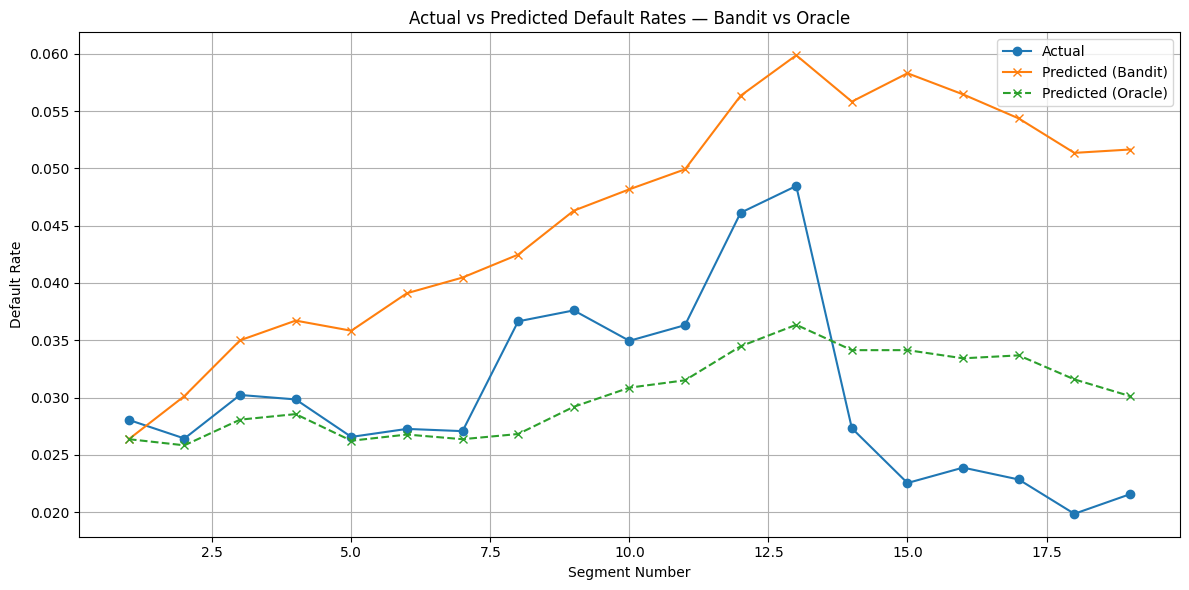

In [39]:
import matplotlib.pyplot as plt

df_bandit = results_df[results_df["type"] == "bandit"].sort_values("segment_num")
df_oracle = results_df[results_df["type"] == "oracle"].sort_values("segment_num")
plt.figure(figsize=(12, 6))

# Bandit
plt.plot(df_bandit["segment_num"], df_bandit["actual_default_rate"], label="Actual", marker='o')
plt.plot(df_bandit["segment_num"], df_bandit["predicted_default_rate"], label="Predicted (Bandit)", marker='x')

# Oracle
plt.plot(df_oracle["segment_num"], df_oracle["predicted_default_rate"], label="Predicted (Oracle)", marker='x', linestyle='--')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rates — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot2.pdf', format='pdf')
plt.show()


## Recall = $\frac{TP}{TP + FN}$ , Specificity = $\frac{TN}{TN + FP}$ 

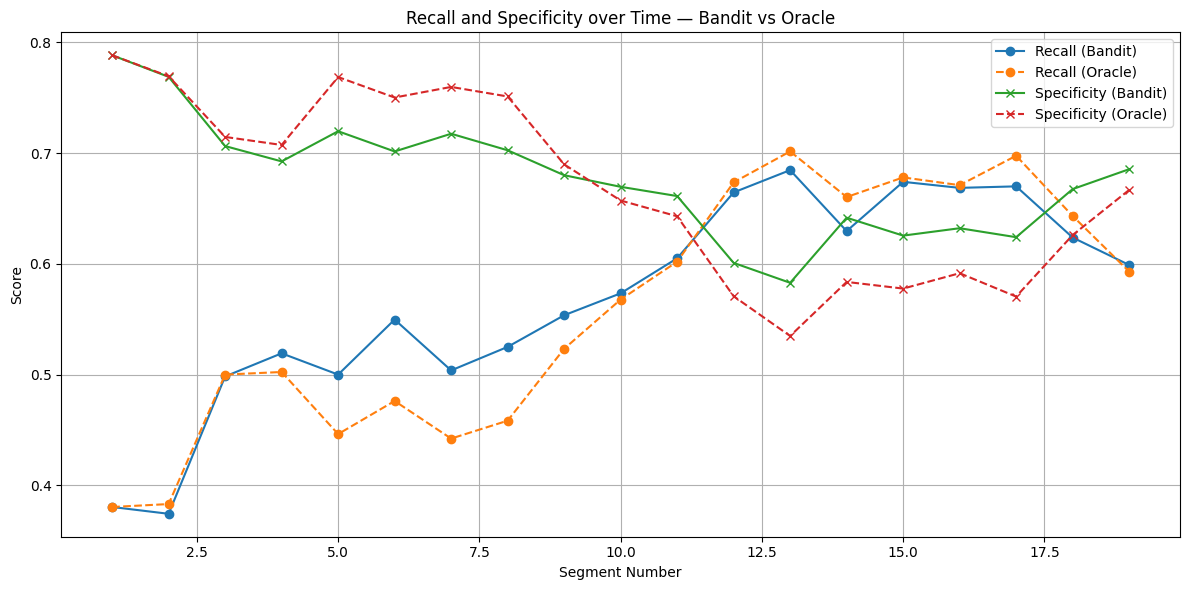

In [40]:
plt.figure(figsize=(12, 6))

plt.plot(df_bandit["segment_num"], df_bandit["recall"], label="Recall (Bandit)", marker='o')
plt.plot(df_oracle["segment_num"], df_oracle["recall"], label="Recall (Oracle)", marker='o', linestyle='--')
plt.plot(df_bandit["segment_num"], df_bandit["specificity"], label="Specificity (Bandit)", marker='x')
plt.plot(df_oracle["segment_num"], df_oracle["specificity"], label="Specificity (Oracle)", marker='x', linestyle='--')
plt.xlabel("Segment Number")
plt.ylabel("Score")
plt.title("Recall and Specificity over Time — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot3.pdf', format='pdf')
plt.show()

Interperetation of results:


Threshold not used: 0.9300
Predicted defaulters: 40802
Predicted non-defaulters: 35541
Max predicted probability: 0.9710
Threshold used: 0.0200
Threshold not used: 0.9500
Predicted defaulters: 36013
Predicted non-defaulters: 28559
Max predicted probability: 0.6811
Threshold used: 0.0200
Threshold not used: 0.9600
Predicted defaulters: 55119
Predicted non-defaulters: 24663
Max predicted probability: 0.8181
Threshold used: 0.0200
Threshold not used: 0.9800
Predicted defaulters: 57384
Predicted non-defaulters: 28128
Max predicted probability: 0.9274
Threshold used: 0.0200
Threshold not used: 0.9700
Predicted defaulters: 48027
Predicted non-defaulters: 39575
Max predicted probability: 1.0000
Threshold used: 0.0200
Threshold not used: 0.9900
Predicted defaulters: 62822
Predicted non-defaulters: 46445
Max predicted probability: 1.0000
Threshold used: 0.0200
Threshold not used: 0.9900
Predicted defaulters: 52443
Predicted non-defaulters: 40585
Max predicted probability: 0.7958
Threshold used:

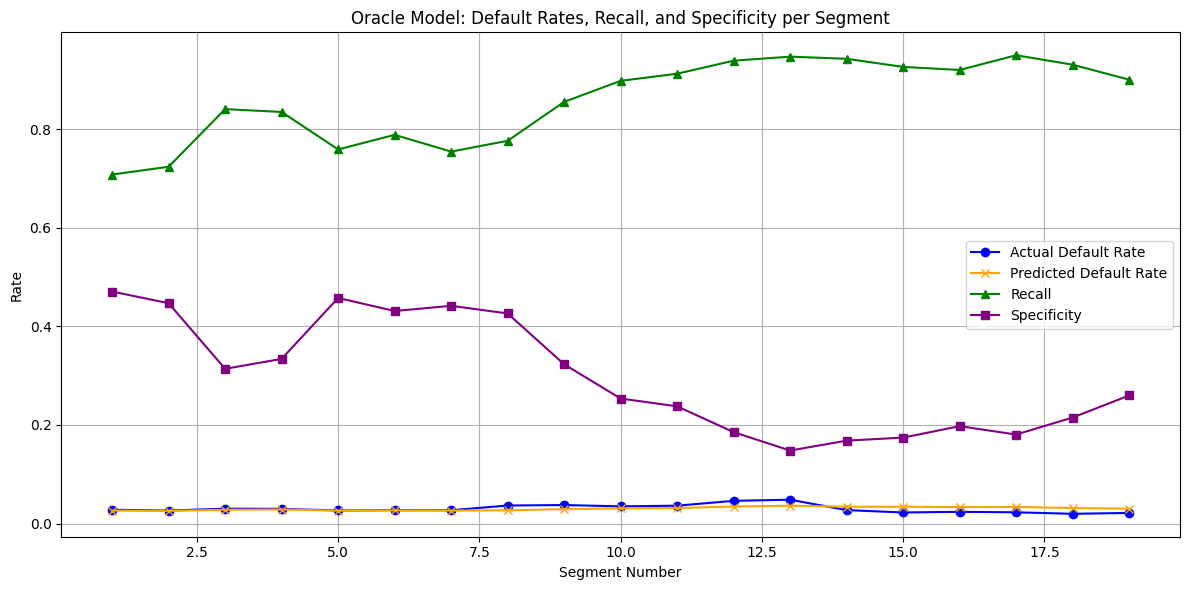

In [36]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# --- Helper functions ---

def compute_recall_specificity(y_true, y_pred_label):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_label).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    return recall, specificity

def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_threshold = 0.5
    best_utility = -np.inf
    for t in thresholds:
        approve = y_pred_proba < t
        approve_good = ((approve == 1) & (y_true == 0)).sum()
        approve_bad = ((approve == 1) & (y_true == 1)).sum()
        reject_good = ((approve == 0) & (y_true == 0)).sum()
        utility = 1 * approve_good + (-20000) * approve_bad -10000*reject_good
        if utility > best_utility:
            best_utility = utility
            best_threshold = t
    return best_threshold

# --- Setup ---

exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[1]))
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

# Initialize tracking lists
segment_nums, recalls, specificities, actual_rates, predicted_rates = [], [], [], [], []

# Start with initial training data
X_train = final_segments['split_0'][features]
y_train = final_segments['split_0']['target']

# Loop through test splits
for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # Train oracle model on all available data
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    predicted_rate = y_pred_proba.mean()
    actual_rate = y_test.mean()

    # Find best threshold using training data
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    best_thresh = find_best_threshold(y_train, y_pred_proba_train)
    print(f"Threshold not used: {best_thresh:.4f}")
    best_thresh = min(best_thresh, 0.02)
    # Compute recall and specificity at best threshold
    y_pred_label = (y_pred_proba >= best_thresh).astype(int)

    num_defaulters = y_pred_label.sum()
    num_non_defaulters = (y_pred_label == 0).sum()

    print(f"Predicted defaulters: {num_defaulters}")
    print(f"Predicted non-defaulters: {num_non_defaulters}")

    print(f"Max predicted probability: {y_pred_proba.max():.4f}")
    print(f"Threshold used: {best_thresh:.4f}")


    recall, specificity = compute_recall_specificity(y_test, y_pred_label)

    # Track results
    segment_nums.append(t)
    recalls.append(recall)
    specificities.append(specificity)
    actual_rates.append(actual_rate)
    predicted_rates.append(predicted_rate)

    # Oracle sees all of current test segment
    X_train = pd.concat([X_train, X_test], ignore_index=True)
    y_train = pd.concat([y_train, y_test], ignore_index=True)

# --- Plot all metrics ---

plt.figure(figsize=(12, 6))

plt.plot(segment_nums, actual_rates, marker='o', label="Actual Default Rate", color='blue')
plt.plot(segment_nums, predicted_rates, marker='x', label="Predicted Default Rate", color='orange')
plt.plot(segment_nums, recalls, marker='^', label="Recall", color='green')
plt.plot(segment_nums, specificities, marker='s', label="Specificity", color='purple')

plt.xlabel("Segment Number")
plt.ylabel("Rate")
plt.title("Oracle Model: Default Rates, Recall, and Specificity per Segment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


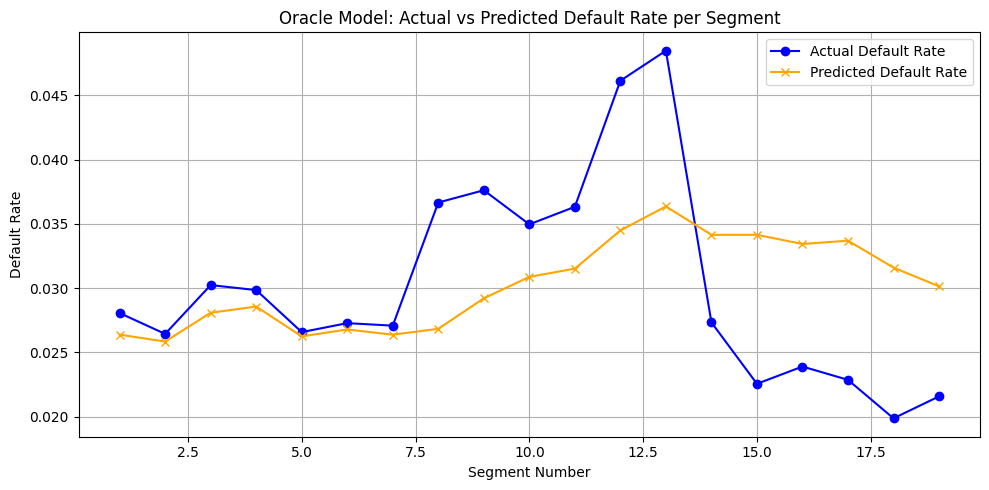

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(segment_nums, actual_rates, marker='o', label="Actual Default Rate", color='blue')
plt.plot(segment_nums, predicted_rates, marker='x', label="Predicted Default Rate", color='orange')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Oracle Model: Actual vs Predicted Default Rate per Segment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
import pandas as pd

results = []
exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

X_train_bandit = final_segments['split_0'][features]
y_train_bandit = final_segments['split_0']['target']

X_train_oracle = X_train_bandit.copy()
y_train_oracle = y_train_bandit.copy()

# Define the SGD model (online logistic regression)
model_bandit = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)
)
model_oracle = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)
)

# Initial fit (important for setting up internal parameters)
model_bandit.fit(X_train_bandit, y_train_bandit)
model_oracle.fit(X_train_oracle, y_train_oracle)

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # BANDIT
    y_pred_proba_bandit = model_bandit.predict_proba(X_test)[:, 1]
    auc_bandit = roc_auc_score(y_test, y_pred_proba_bandit)
    y_pred_bandit = (y_pred_proba_bandit >= 0.03).astype(int)
    accept_mask_bandit = y_pred_proba_bandit < 0.03
    recall_bandit = recall_score(y_test, y_pred_bandit)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bandit).ravel()
    specificity_bandit = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "bandit",
        "auc": auc_bandit,
        "recall": recall_bandit,
        "specificity": specificity_bandit,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_bandit.mean(),
        "accept_rate": accept_mask_bandit.mean()
    })

    # Update bandit with only accepted applicants
    if accept_mask_bandit.any():
        model_bandit.named_steps['sgdclassifier'].partial_fit(
            StandardScaler().fit_transform(X_test[accept_mask_bandit]), 
            y_test[accept_mask_bandit], 
            classes=[0, 1]
        )

    # ORACLE
    y_pred_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)
    y_pred_oracle = (y_pred_proba_oracle >= 0.03).astype(int)
    accept_mask_oracle = y_pred_proba_oracle < 0.03
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean()
    })

    # Update oracle with full test data
    model_oracle.named_steps['sgdclassifier'].partial_fit(
        StandardScaler().fit_transform(X_test),
        y_test,
        classes=[0, 1]
    )

results_df = pd.DataFrame(results)


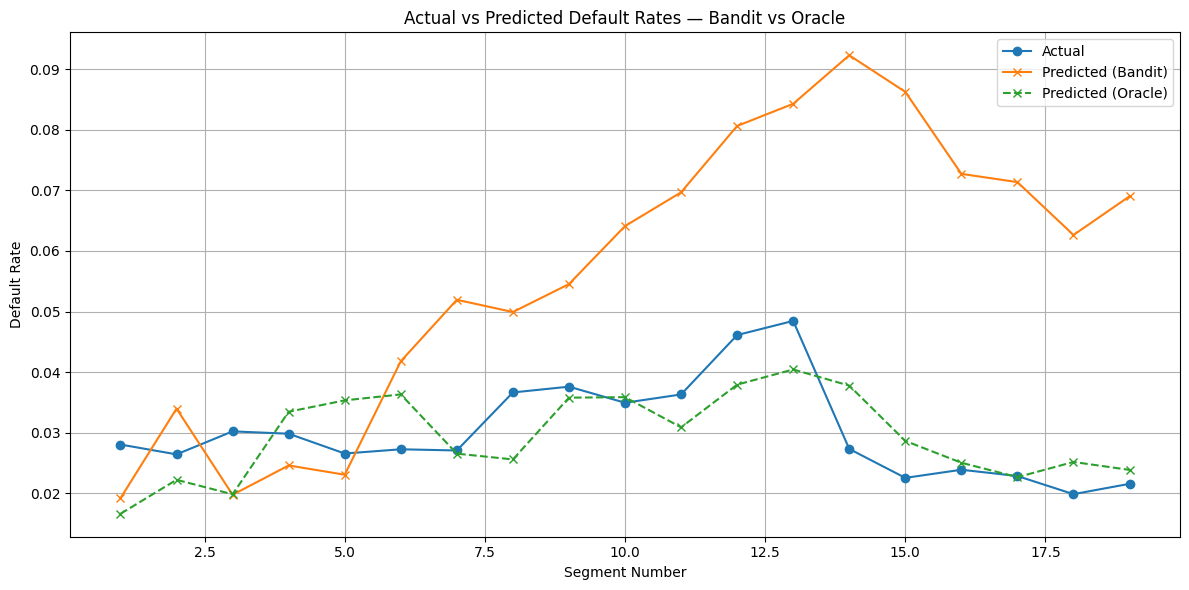

In [42]:
import matplotlib.pyplot as plt

df_bandit = results_df[results_df["type"] == "bandit"].sort_values("segment_num")
df_oracle = results_df[results_df["type"] == "oracle"].sort_values("segment_num")
plt.figure(figsize=(12, 6))

# Bandit
plt.plot(df_bandit["segment_num"], df_bandit["actual_default_rate"], label="Actual", marker='o')
plt.plot(df_bandit["segment_num"], df_bandit["predicted_default_rate"], label="Predicted (Bandit)", marker='x')

# Oracle
plt.plot(df_oracle["segment_num"], df_oracle["predicted_default_rate"], label="Predicted (Oracle)", marker='x', linestyle='--')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rates — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot4.pdf', format='pdf')
plt.show()

In [41]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
import pandas as pd

results = []

exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

X_train_bandit = final_segments['split_0'][features]
y_train_bandit = final_segments['split_0']['target']

X_train_oracle = X_train_bandit.copy()
y_train_oracle = y_train_bandit.copy()

# Define scalers and classifiers
scaler_bandit = StandardScaler()
scaler_oracle = StandardScaler()

clf_bandit = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)
clf_oracle = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)

# Initial fit (scaler + classifier)
X_bandit_scaled = scaler_bandit.fit_transform(X_train_bandit)
X_oracle_scaled = scaler_oracle.fit_transform(X_train_oracle)

clf_bandit.partial_fit(X_bandit_scaled, y_train_bandit, classes=[0, 1])
clf_oracle.partial_fit(X_oracle_scaled, y_train_oracle, classes=[0, 1])

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # BANDIT
    scaler_bandit.partial_fit(X_test)  # update running mean/var
    X_test_scaled_bandit = scaler_bandit.transform(X_test)

    y_pred_proba_bandit = clf_bandit.predict_proba(X_test_scaled_bandit)[:, 1]
    y_pred_bandit = (y_pred_proba_bandit >= 0.03).astype(int)
    accept_mask_bandit = y_pred_proba_bandit < 0.03
    auc_bandit = roc_auc_score(y_test, y_pred_proba_bandit)
    recall_bandit = recall_score(y_test, y_pred_bandit)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bandit).ravel()
    specificity_bandit = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "bandit",
        "auc": auc_bandit,
        "recall": recall_bandit,
        "specificity": specificity_bandit,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_bandit.mean(),
        "accept_rate": accept_mask_bandit.mean()
    })

    # Update bandit model only with accepted applicants
    if accept_mask_bandit.any():
        clf_bandit.partial_fit(
            X_test_scaled_bandit[accept_mask_bandit],
            y_test[accept_mask_bandit],
            classes=[0, 1]
        )

    # ORACLE 
    scaler_oracle.partial_fit(X_test)  # update running mean/var
    X_test_scaled_oracle = scaler_oracle.transform(X_test)

    y_pred_proba_oracle = clf_oracle.predict_proba(X_test_scaled_oracle)[:, 1]
    y_pred_oracle = (y_pred_proba_oracle >= 0.03).astype(int)
    accept_mask_oracle = y_pred_proba_oracle < 0.03
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean()
    })

    # Update oracle model with all data
    clf_oracle.partial_fit(
        X_test_scaled_oracle,
        y_test,
        classes=[0, 1]
    )

# Convert to DataFrame
results_df = pd.DataFrame(results)


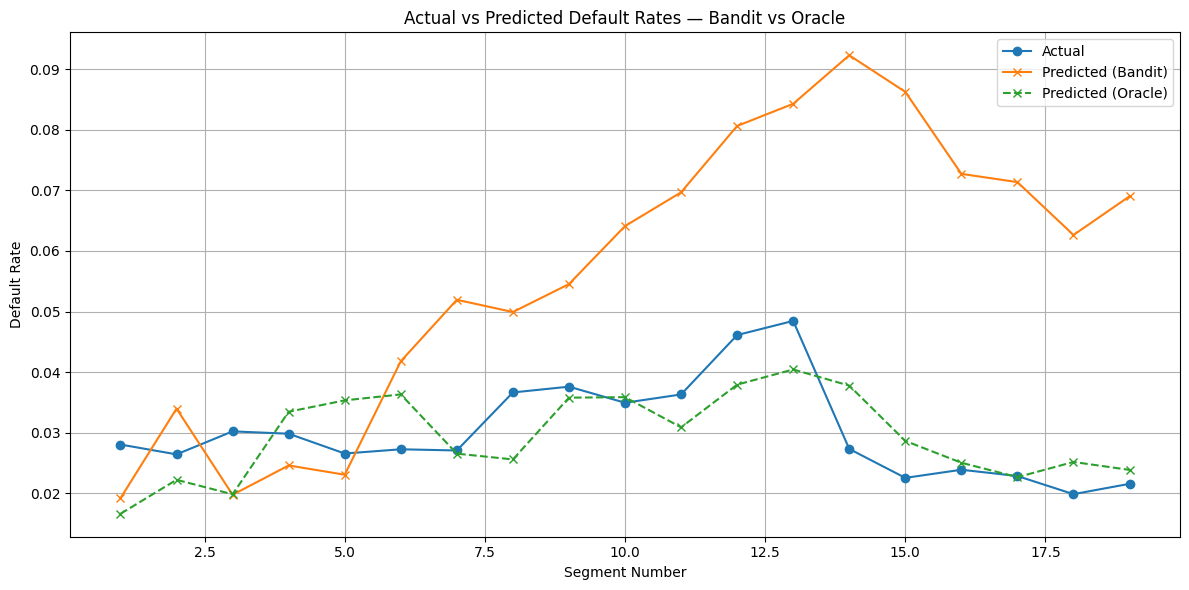

In [44]:
import matplotlib.pyplot as plt

df_bandit = results_df[results_df["type"] == "bandit"].sort_values("segment_num")
df_oracle = results_df[results_df["type"] == "oracle"].sort_values("segment_num")
plt.figure(figsize=(12, 6))

plt.plot(df_bandit["segment_num"], df_bandit["actual_default_rate"], label="Actual", marker='o')
plt.plot(df_bandit["segment_num"], df_bandit["predicted_default_rate"], label="Predicted (Bandit)", marker='x')
plt.plot(df_oracle["segment_num"], df_oracle["predicted_default_rate"], label="Predicted (Oracle)", marker='x', linestyle='--')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rates — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()